In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng
import itertools as it
import sys
import progressbar
import time
import random

from joblib import Parallel, delayed

from scipy import linalg
from scipy.linalg import LinAlgWarning

import pickle

warnings.filterwarnings(action='error', category=LinAlgWarning, module='sklearn')

def stack_xy(A):
    return np.block([[A["xx"], A["xy"]], 
                    [A["xy"], A["yy"]]])

def restructure_dict(list_dic, shape):
    keys = list( list_dic[0].keys() )

    new_dic = dict()
    
    for key in keys:
        new_dic[key] = []
    
    for item in list_dic:
        for key in keys:
            new_dic[key].append(item[key]) 

    for key in keys:
        arr = np.asarray(new_dic[key])
        new_dic[key] = arr.reshape(shape)
        
    return new_dic

In [2]:
def create_G(rx, ry=0., rz=0., k=2.*np.pi, thres_same=0.1, thres_ren=1e-12):
    
    r_in = np.sqrt(rx**2 + ry**2 + rz**2) # input r
    
    rx_ren = rx + thres_ren*np.random.random_sample(r_in.shape)    
    r = np.sqrt(rx_ren**2 + ry**2 + rz**2)  # add some random noise to renormalize for divergences

    
    phase = np.exp(1j*k*r)/(4*np.pi*r)

    G = dict()
    G["xx"] = phase * ( 1. + (1j*k*r-1.)/(k*r)**2 + ( -1. + (3.-3.*1j*k*r)/(k*r)**2) * rx**2/r**2 ) 
    G["yy"] = phase * ( 1. + (1j*k*r-1.)/(k*r)**2 + ( -1. + (3.-3.*1j*k*r)/(k*r)**2) * ry**2/r**2 )
    G["xy"] = phase * ( ( -1. + (3.-3.*1j*k*r)/(k*r)**2) * rx*ry/r**2 )
    
    for key in G.keys():
        G[key][r_in<thres_same] = 0. # set vals with r=0. to zero (don't count emitter interacting with itself)

    return G

def create_G_y_average(rx, y_max, N_y, thres_same=0.1):
    
    N_x = rx.shape[0]
    keys = ['xx', 'yy', 'xy']
    v_y = np.linspace(0., y_max, N_y)
    
    G_mean = create_G(rx, ry=0., thres_same=thres_same)
    for y in v_y[1:]:
        G = create_G(rx, ry=y, thres_same=thres_same)
        
        for key in keys:
            G_mean[key] += 2.*G[key]
            
    for key in keys:
        G_mean[key] = G_mean[key] / (2*N_y-1)
    
    return G_mean
            
    

def create_alpha_array(delta, d_delta, a, r, gamma_0, gamma_nr=0., lambda_a=1., epsilon=12.25):
    gamma = gamma_0 + gamma_nr
    delta_r = delta + d_delta*np.sin(2.*np.pi*r/a)
    return -3./(4.*np.pi**2)*epsilon*lambda_a**3*(gamma_0/2.)/(delta_r+1j*gamma/2.)

def get_far_field(p, n_exc, d_r, epsilon=12.25):
    return np.pi**2/epsilon**2*np.abs(d_r*n_exc*np.sum(p, axis=-1))**2



In [15]:
def get_sample_1D(a, delta, gamma_0, gamma_nr, n_exc, G, d_r, Gaussian=False, d_delta=1., epsilon=12.25):
        
    # beam profile 
    if Gaussian:
        n_0 = n_exc * np.exp(-(v_r-v_r[N_r//2])**2/(2.*width**2))
    else:
        n_0 = n_exc * np.ones(N_r)
    
    # get polarizations
    v_alpha = create_alpha_array(delta, d_delta, a, v_r, gamma_0, gamma_nr=gamma_nr, epsilon=epsilon)
    p_0 = n_0 * v_alpha

    # solve equations to find effective polarizations
    p = dict()
    p['x'] = linalg.solve( np.eye(N_r) - 4.*np.pi**2/epsilon * d_r *(np.diag(v_alpha)@G["xx"]), p_0)
    p['y'] = linalg.solve( np.eye(N_r) - 4.*np.pi**2/epsilon * d_r *(np.diag(v_alpha)@G["yy"]), p_0)
    
    return p

def get_sample(a, delta, gamma_0, gamma_nr, n_exc, G, d_x, d_delta=1., Gaussian=None, epsilon=12.25, only_1D=False):
        
    # beam profile 
    if Gaussian is not None:
        n_0 = n_exc * np.exp(-(v_r-v_r[N_r//2])**2/(2.*Gaussian['width']**2))
    else:
        n_0 = n_exc * np.ones(N_r)
        
    # get dyadic Green's function with correct cutoff
    r_ij = np.abs(v_r[:,None] - v_r[None,:])
    G_dict = create_G(r_ij, thres_same=r_excl)
    G_full = stack_xy(G)
    d_r = v_r[1] - v_r[0]
    
    
    
    # get polarizations
    v_alpha = create_alpha_array(delta, d_delta, a, v_r, gamma_0, gamma_nr=gamma_nr, epsilon=epsilon)
    p_0 = n_0 * v_alpha
    p = dict()
    if only_1D:
        # solve equations to find effective polarizations
        p['x'] = linalg.solve( np.eye(N_r) - 4.*np.pi**2/epsilon * d_r *(np.diag(v_alpha)@G["xx"]), p_0)
        p['y'] = linalg.solve( np.eye(N_r) - 4.*np.pi**2/epsilon * d_r *(np.diag(v_alpha)@G["yy"]), p_0)
        
    else:
        Gd = stack_xy(G)
        pd_0 = np.concatenate((p_0,p_0))
        alphad = np.concatenate((v_alpha,v_alpha))
        pd = linalg.solve( np.eye(2*N_r) - 4.*np.pi**2/epsilon * d_r *(np.diag(alphad)@Gd), pd_0)
        p['x'] = pd[:N_r]
        p['y'] = pd[N_r:]
    
    return p

## plot intensity (a,\Delta\omega)

In [ ]:
# system parameters
gamma_0 = 1. # radiative losses
gamma_nr = 0. # non-radiative losses
n_exc = 10. # exciton density (units 1/\lambda)

r_max = 10. # for simulation maximal r sample
N_r = 400 # number of points for discretization

y_average = True
y_max = r_max
N_y = N_r

# modulated exciton shift amplitude
D_min = 0.
D_max = 2.
N_D = 30

# delta to evaluate to obtain
delta_min = -2.*D_max # detuning from bare resonance
delta_max = 2.*D_max
N_delta = 100

# for the paralel loop
a_min = 1e-6 # a's to scan
a_max = 1.
N_a = 41


########################################

v_r = np.linspace(0., r_max, N_r)
r_ij = np.abs(v_r[:,None] - v_r[None,:])
d_r = v_r[1] - v_r[0]
r_excl = 0.5/n_exc

if y_average:
    G = create_G_y_average(r_ij, y_max, N_y, thres_same=r_excl)
else:
    G = create_G(r_ij, thres_same=r_excl)


v_D = np.linspace(D_min, D_max, N_D)
v_a = np.linspace(a_min, a_max, N_a)
v_delta = np.linspace(delta_min, delta_max, N_delta)

# parallel loop
polarization_pp = Parallel(n_jobs=-1)(delayed(get_sample)
                                      (a, delta, gamma_0, gamma_nr, n_exc, G, d_r, d_delta=D) 
                                      for a in v_a for D in v_D for delta in v_delta)

# restructure result (bring keys outward)
polarization = restructure_dict(polarization_pp, shape=(N_a,N_D,N_delta,N_r))

# get far fields
for key in list(polarization.keys()):
    polarization['ff'+key] = get_far_field(polarization[key], n_exc, d_r)

In [ ]:
_ = plt.pcolormesh(v_a,v_D, np.max(polarization['ffy'],axis=-1).T, shading="auto")
plt.xlabel(r"$a/\lambda$")
plt.ylabel(r"$\Delta\omega/\gamma_0$")
plt.colorbar()
#plt.savefig("2D_intensity_n_20_gamma_nr_0.pdf")

In [ ]:
D = 1.
#a = 0.2
i_D = np.argmin(np.abs(D-v_D))
#i_a = np.argmin(np.abs(a-v_a))

_ = plt.pcolormesh(v_a,v_delta, polarization['ffy'][:,i_D,:].T, shading="auto")
plt.xlabel(r"$a/\lambda$")
plt.ylabel(r"$\delta/\gamma_0$")
plt.colorbar()

Text(0, 0.5, 'Intensity (A.U.)')

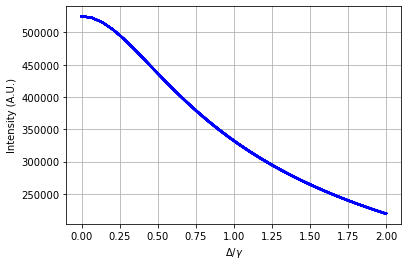

In [8]:
a = .4

ind = np.argmin(np.abs(a-v_a))

plt.plot(v_D, np.sum(polarization['ffx'],axis=-1)[:].T, 'b', label='x-polarized', linewidth=2.)
#plt.plot(v_D, polarization['ffx'][0].T, 'r', label='y-polarized', linewidth=2.)
#plt.legend()
plt.grid(True)
plt.xlabel(r"$\Delta/\gamma$")
plt.ylabel("Intensity (A.U.)")

   ## plot (a,\delta)

In [20]:
# system parameters
d_omega = 1.
gamma_0 = 1. # radiative losses
gamma_nr = 0. # non-radiative losses
n_exc = 10. # exciton density (units 1/\lambda)

r_max = 5. # for simulation maximal r sample
N_r = 400 # number of points for discretization

y_average = True
y_max = r_max
N_y = N_r

# for the paralel loop
delta_min = -4.*d_omega # delta's to scan over
delta_max  = 4.*d_omega
N_delta = 100

a_min = 1e-6 # a's to scan
a_max = 10
N_a = 100

Gaussian = {'width': r_max/4.}


########################################

v_r = np.linspace(0., r_max, N_r)
r_ij = np.abs(v_r[:,None] - v_r[None,:])
d_r = v_r[1] - v_r[0]
r_excl = 0.5/n_exc

if y_average:
    G = create_G_y_average(r_ij, y_max, N_y, thres_same=r_excl)
else:
    G = create_G(r_ij, thres_same=r_excl)


v_delta = np.linspace(delta_min, delta_max, N_delta)
v_a = np.linspace(a_min, a_max, N_a)

# parallel loop
polarization_pp = Parallel(n_jobs=-1)(delayed(get_sample)
                                      (a, delta, gamma_0, gamma_nr, n_exc, G, d_r, d_delta=d_omega, Gaussian=Gaussian) 
                                      for a in v_a for delta in v_delta)

# get bare result
polarization_bare_pp = Parallel(n_jobs=-1)(delayed(get_sample)
                                           (1., delta, gamma_0, gamma_nr, n_exc, G, d_r, d_delta=0., Gaussian=Gaussian) 
                                           for delta in v_delta )

# restructure result (bring keys outward)
polarization = restructure_dict(polarization_pp, shape=(N_a,N_delta,N_r))
polarization_bare = restructure_dict(polarization_bare_pp, shape=(N_delta,N_r))

# get far fields
for key in list(polarization.keys()):
    polarization['ff'+key] = get_far_field(polarization[key], n_exc, d_r)
    polarization_bare['ff'+key] = get_far_field(polarization_bare[key], n_exc, d_r)


Text(0, 0.5, 'Intensity (A.U.)')

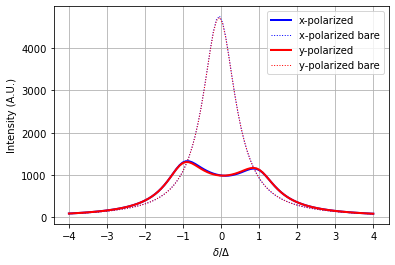

In [22]:
a = .1

ind = np.argmin(np.abs(a-v_a))

plt.plot(v_delta, polarization['ffx'][ind].T, 'b', label='x-polarized', linewidth=2.)
plt.plot(v_delta, polarization_bare['ffx'], ':b', label='x-polarized bare', linewidth=1.)
plt.plot(v_delta, polarization['ffy'][ind].T, 'r', label='y-polarized', linewidth=2.)
plt.plot(v_delta, polarization_bare['ffy'], ':r', label='y-polarized bare', linewidth=1.)
plt.legend()
plt.grid(True)
plt.xlabel(r"$\delta/\Delta$")
plt.ylabel("Intensity (A.U.)")

#plt.savefig("yspan_{:.2f}.pdf".format(y_max))

<ipython-input-18-66443ac997f9>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  _ = plt.pcolormesh(v_a,v_delta, polarization['ffx'].T)


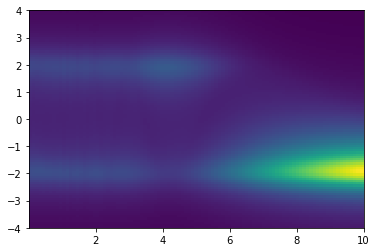

In [18]:
_ = plt.pcolormesh(v_a,v_delta, polarization['ffx'].T)

<ipython-input-17-66443ac997f9>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  _ = plt.pcolormesh(v_a,v_delta, polarization['ffx'].T)


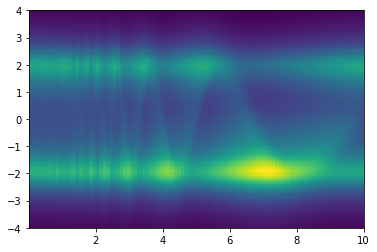

In [17]:
_ = plt.pcolormesh(v_a,v_delta, polarization['ffx'].T)

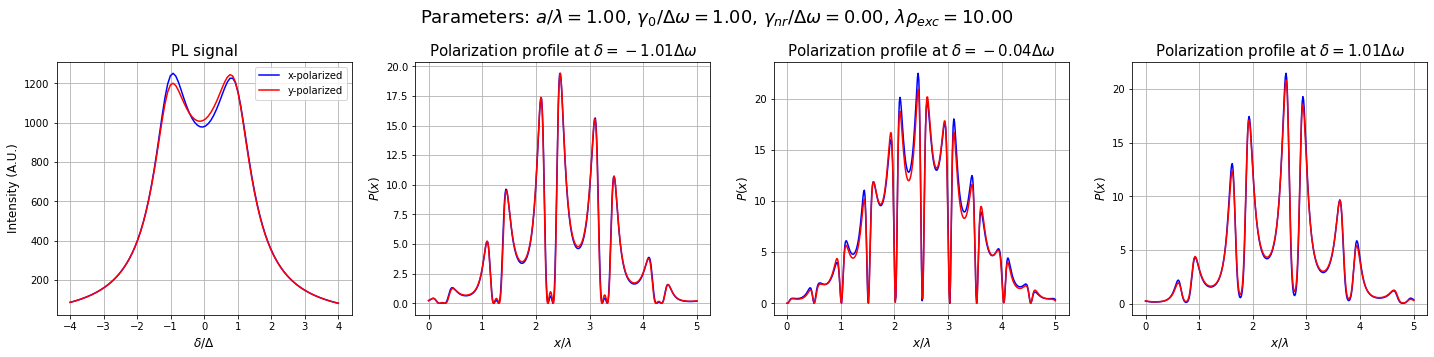

In [25]:
# plot induced polarization profile for set of delta's
a_plot = 1.
delta_plot = [-1.,0.,1.]

labelsize = 12
titlesize = 15

# plot
fig, ax = plt.subplots(1,len(delta_plot)+1, figsize=(5*(1+len(delta_plot)),5))
fig.suptitle(r"Parameters: $a/\lambda={:.2f}$, $\gamma_0/\Delta\omega={:.2f}$, $\gamma_{{nr}}/\Delta\omega={:.2f}$, $\lambda\rho_{{exc}}={:.2f}$".format(a_plot, gamma_0, gamma_nr, n_exc), fontsize=18)

i_a = np.argmin(np.abs(v_a-a_plot))

ax[0].plot(v_delta, polarization["ffx"][i_a], color="b", label="x-polarized")
ax[0].plot(v_delta, polarization["ffy"][i_a], color="r", label="y-polarized")
ax[0].set_xlabel(r"$\delta/\Delta$", fontsize=labelsize)
ax[0].set_ylabel("Intensity (A.U.)", fontsize=labelsize)
ax[0].set_title("PL signal", fontsize=titlesize)
ax[0].grid(True)
ax[0].legend()

for i_p, dp in enumerate(list(delta_plot)):
    i_d = np.argmin(np.abs(dp-v_delta))

    ax[i_p+1].plot( v_r, np.real(polarization["x"][i_a,i_d])**2,"-", color="b")
    ax[i_p+1].plot( v_r, np.real(polarization["y"][i_a,i_d])**2,"-", color="r")

    ax[i_p+1].set_xlabel(r"$x/\lambda$", fontsize=labelsize)
    ax[i_p+1].set_ylabel(r"$P(x)$", fontsize=labelsize)
    ax[i_p+1].set_title(r"Polarization profile at $\delta={:.2f}\Delta\omega$".format(v_delta[i_d]), fontsize=titlesize)
    ax[i_p+1].grid(True)
    
plt.tight_layout(pad=1., w_pad=1.5, h_pad=0.)

#plt.savefig("n_{:.2f}.pdf".format(n_exc))

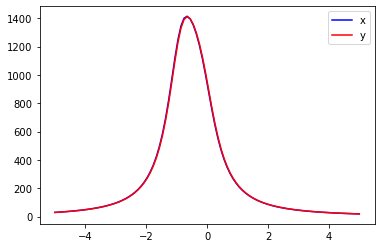

In [116]:
a = 10

ind = np.argmin(np.abs(a-v_a))

_ = plt.plot(v_delta, polarization['ffx'][ind].T, 'b', label='x')
_ = plt.plot(v_delta, polarization['ffy'][ind].T, 'r', label='y')
_ = plt.legend()